In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard
import sklearn as sk
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub

Constantes a definir

In [2]:
RUTA_TRAIN = "./tfg_dataset/train"
RUTA_TEST = "./tfg_dataset/test"
DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2

Funciones para visualizar un ejemplo del dataset creado con `image_dataset_from_directory` y con `flow_from_directory`

In [3]:
def sample_ds_dfd(ds): 
    for i, (img, label) in enumerate(ds.unbatch().take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(ds.class_names[np.argmax(label)], fontsize = 8)
        plt.axis("off")

def sample_ds_ffd(ds): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)], fontsize = 8)
        plt.imshow(img)
        plt.axis("off")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos). 

In [4]:
x_train, x_val = image_dataset_from_directory(
    directory = RUTA_TRAIN,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 586 files belonging to 4 classes.
Using 469 files for training.
Using 117 files for validation.


De manera similar se realiza para los datos utilizados para evaluar el modelo. 

In [5]:
x_test = image_dataset_from_directory(
    directory = RUTA_TEST,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

Found 102 files belonging to 4 classes.


Se normalizan los valores de las imágenes para facilitar el trabajo a la red

In [6]:
class_names = x_train.class_names
norm = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x, y: (norm(x), y))
x_val = x_val.map(lambda x, y: (norm(x), y))
x_test = x_test.map(lambda x, y: (norm(x), y))
x_train.class_names = class_names
x_val.class_names = class_names
x_test.class_names = class_names

Se muestran algunos ejemplos del dataset

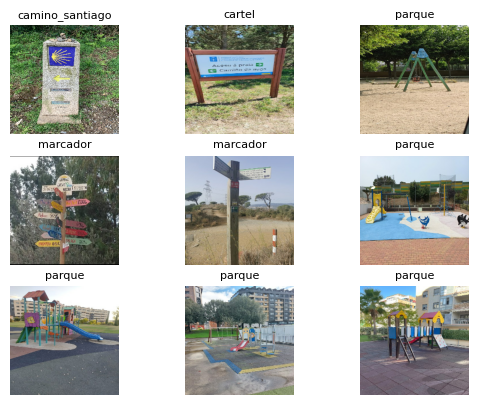

In [7]:
sample_ds_dfd(x_train)

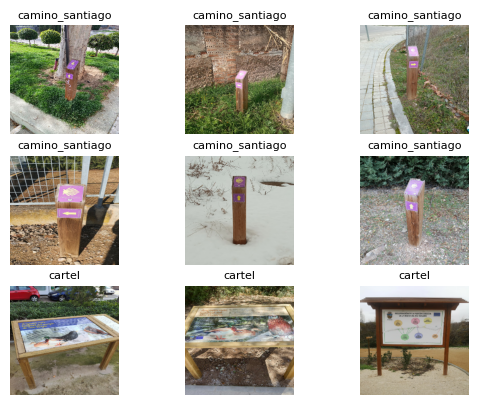

In [8]:
sample_ds_dfd(x_test)

Se crea un modelo basado en uno ya entrenado de TensorHub

In [9]:
url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
red_hub = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub.summary()
red_hub.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________



Se realiza el entrenamiento del modelo

In [10]:
%load_ext tensorboard
red_hub.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs_mobilenet")])

Epoch 1/25



15/15 [==============================] - 9s 353ms/step - loss: 0.8723 - accuracy: 0.6780 - val_loss: 0.4509 - val_accuracy: 0.8974
Epoch 2/25
15/15 [==============================] - 5s 295ms/step - loss: 0.2930 - accuracy: 0.9403 - val_loss: 0.2375 - val_accuracy: 0.9487
Epoch 3/25
15/15 [==============================] - 5s 270ms/step - loss: 0.1650 - accuracy: 0.9595 - val_loss: 0.1611 - val_accuracy: 0.9573
Epoch 4/25
15/15 [==============================] - 5s 268ms/step - loss: 0.1129 - accuracy: 0.9744 - val_loss: 0.1357 - val_accuracy: 0.9573
Epoch 5/25
15/15 [==============================] - 5s 266ms/step - loss: 0.0866 - accuracy: 0.9872 - val_loss: 0.1170 - val_accuracy: 0.9573
Epoch 6/25
15/15 [==============================] - 5s 260ms/step - loss: 0.0719 - accuracy: 0.9936 - val_loss: 0.1065 - val_accuracy: 0.9658
Epoch 7/25
15/15 [==============================] - 4s 254ms/step - loss: 0.0598 - accuracy: 0.9936 - val_loss: 0.0971 - val_accuracy: 0.9658
Epoch 8/25
15/15 

Se hacen las predicciones sobre el conjunto de test para evaluar el modelo

In [11]:
def predict_dataset(ds, modelo): 
    y_target = []
    y_hat = []
    y_confidence = []
    batches = len(ds)
    for batch, (img_batch, label_batch) in enumerate(ds): 
        if batch == batches: 
            break
        else: 
            for img, label in zip(img_batch, label_batch):
                y_target.append(np.argmax(label))
                y_hat.append(np.argmax(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)[0]))
                y_confidence.append(np.max(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)))
    return np.column_stack((y_target, y_hat, y_confidence)), modelo.predict(ds, verbose = 0)

Y_matrix, Y_score = predict_dataset(x_test, red_hub)

Se muestran las 9 primeras predicciones como ejemplo

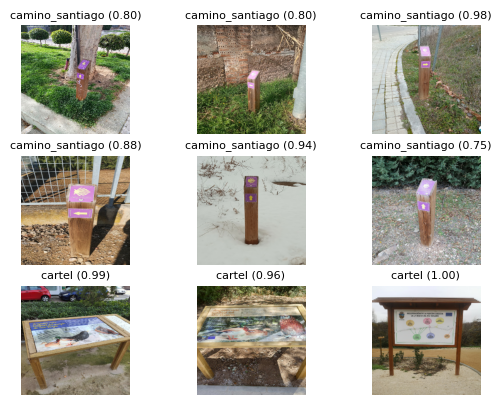

In [12]:
def sample_predict_ds_fd(ds, Y_matrix): 
    for img_batch, _ in ds.take(1):
        for i, img in enumerate(img_batch): 
            prediccion = int(Y_matrix[i, 1])
            plt.subplot(3, 3, i + 1)
            plt.title(f"{ds.class_names[prediccion]} ({Y_matrix[i, 2]:.2f})", fontsize = 8)
            plt.imshow(img.numpy())
            plt.axis("off")
            if i == 8: 
                break

sample_predict_ds_fd(x_test, Y_matrix)

### Métricas
¿Realmente ha sido un buen modelo? 
#### Matriz de confusión

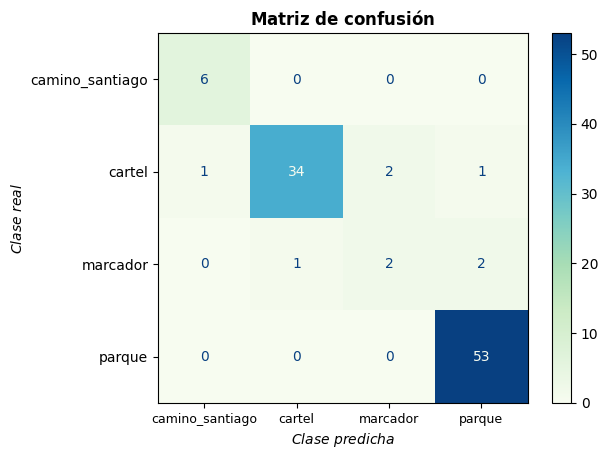

In [13]:
def matriz_confusion(ds, Y_matrix): 
    cm = sk.metrics.confusion_matrix(Y_matrix[:, 0], Y_matrix[:, 1])
    diagrama = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ds.class_names).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    diagrama.ax_.set_title(r"$\mathbf{Matriz\ de\ confusión}$")
    diagrama.ax_.set_xlabel(r"$\mathit{Clase\ predicha}$")
    diagrama.ax_.set_ylabel(r"$\mathit{Clase\ real}$")
    diagrama.ax_.tick_params(axis = "x", labelsize = 9)

matriz_confusion(x_test, Y_matrix)

#### Resumen de métricas

* **Precisión**: de todos los elementos clasificados como $C_i$, ¿cuántos realmente pertenecen a dicha clase?
$$
\mathcal{P} = P(C_i | \hat{C}_i) = \frac{P(C_i \cap \hat{C}_i)}{P(\hat{C}_i)}
$$

* **Sensibilidad**: de todos los elementos de la clase $C_i$, ¿cuántos se han clasificado como tal?
$$
\mathcal{R} = P(\hat{C}_i | C_i) = \frac{P(\hat{C}_i \cap C_i)}{P(C_i)}
$$

* $F_1-$ Score: en general, ¿cómo de bueno es el clasificador?
$$
F_1 = \frac{2}{\mathcal{P}^{-1} + \mathcal{R}^{-1}}
$$

In [14]:
def metricas_matriz_confusion(ds, Y_matrix, dict = False):
    return sk.metrics.classification_report(
                                 Y_matrix[:, 0], Y_matrix[:, 1], 
                                 target_names = ds.class_names, 
                                 digits = 3, 
                                 output_dict = dict
                                )

print(metricas_matriz_confusion(x_test, Y_matrix))

                 precision    recall  f1-score   support

camino_santiago      0.857     1.000     0.923         6
         cartel      0.971     0.895     0.932        38
       marcador      0.500     0.400     0.444         5
         parque      0.946     1.000     0.972        53

       accuracy                          0.931       102
      macro avg      0.819     0.824     0.818       102
   weighted avg      0.929     0.931     0.928       102



* Coeficiente $\kappa$ de Cohen: otra manera de medir la calidad del clasificador. 

In [15]:
def kappa_cohen(Y_matrix): 
    return sk.metrics.cohen_kappa_score(Y_matrix[:, 0], Y_matrix[:, 1]).round(3)

kappa_cohen(Y_matrix)

0.882

* Curvas ROC y área AUC: en el caso de varias clases existen diferentes formas de interpretar y calcular las curvas ROC y su AUC. Predominan los algoritmos OvO y OvR. OvO consiste en realizar una media ponderada de los $2\binom{c}{2}$ posibles AUC. Es decir, para cada posible pareja de clases se considera como un caso de clasificación binaria donde se representa $P(\hat{C}_i | C_i)$ frente a $P(\hat{C}_i | C_j)$, y $P(\hat{C}_j | C_j)$ frente a $P(\hat{C}_j | C_i)$ y cada AUC obtenido se pondera respectivamente mediante $P(C_i)$ y $P(C_j)$. De esta manera el mal AUC de una pareja es proporcional al número de observaciones de las clases que compara, siendo útil para casos de clases desbalanceadas como este. 
$$
\mathcal{A}_{\text{ovo}} = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k \neq j}^c P(C_j)\mathcal{A}(C_j | C_k) = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k > j}^c P(C_j \cup C_k)(\mathcal{A}(C_j | C_k) + \mathcal{A}(C_k | C_j))
$$

In [16]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovr", average = "weighted")

0.9887533621696101

In [17]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovo", average = "weighted")

0.9678940769731704

Para hacerlo un poco más ilustrativo, se puede programar una función propia de AUC OvR donde se vean las gráficas correspondientes a las $c$ clases. 

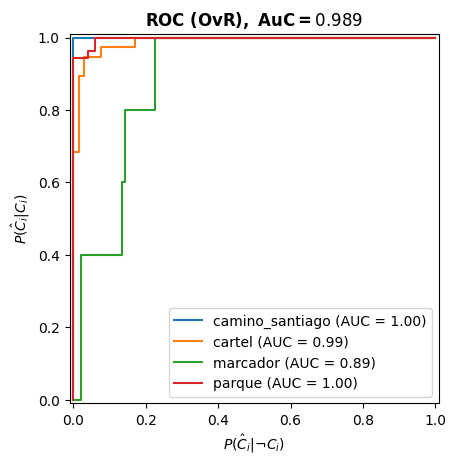

0.9887533621696103

In [18]:
def roc_auc_ovr(Y_matrix, Y_score, clases): 
    Y_ms = np.column_stack((Y_matrix[:, :-1], Y_score))
    _, ax = plt.subplots()
    auc_ovr = 0

    for i in range(Y_score.shape[1]): 
        Y_ms_temp = Y_ms.copy()
        Y_ms_temp[:, 0] = np.where(Y_ms_temp[:, 0] != i, -1, 1)
        fpr, tpr, _ = sk.metrics.roc_curve(y_true = Y_ms_temp[:, 0], y_score = Y_ms_temp[:, i + 2], pos_label = 1)
        auc = sk.metrics.auc(fpr, tpr)
        prop = np.mean(Y_ms_temp[:, 0] == 1)
        auc_ovr += auc * prop
        sk.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f"{clases[i]}").plot(ax = ax)
    
    ax.set_title(r"$\mathbf{ROC\ (OvR),\ AuC = }$" + str(auc_ovr.round(3)))
    ax.set_xlabel(r"$P(\hat{C}_i | \neg C_i)$")
    ax.set_ylabel(r"$P(\hat{C}_i | C_i)$")
    plt.show()
    return auc_ovr

roc_auc_ovr(Y_matrix, Y_score, x_val.class_names)

Se pueden asociar todas en una única función por comodidad: 

In [19]:
def metricas_prediccion(ds, Y_matrix, Y_score): 
    matriz_confusion(ds, Y_matrix)
    print(metricas_matriz_confusion(ds, Y_matrix))
    print(f"Kappa de Cohen: {kappa_cohen(Y_matrix)}")
    print(f"AUC (OvO): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovo', average = 'weighted').round(3)}")
    print(f"AUC (OvR): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovr', average = 'weighted').round(3)}")
    roc_auc_ovr(Y_matrix, Y_score, ds.class_names)

Se va a proceder a la técnica del aumento de datos. Se va a crear el mismo dataset pero haciendo modificaciones sobre las imágenes, de manera que se reentrene la red aprendiendo a extraer las mismas características de imágenes similares. 

In [20]:
generador_original = ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 470 images belonging to 4 classes.
Found 116 images belonging to 4 classes.


Found 470 images belonging to 4 classes.
Found 116 images belonging to 4 classes.


Se muestran las imágenes modificadas

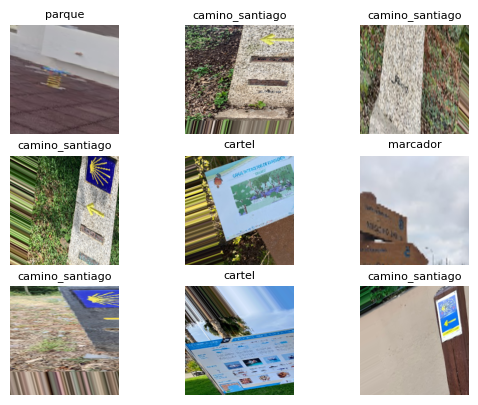

In [21]:
sample_ds_ffd(x_train_au)

Ahora se crea un modelo igual para entrenarlo y comprobar si esta técnica aporta diferencias al entrenamiento

In [22]:
red_hub_au = tf.keras.Sequential([
    hub.KerasLayer(url, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_hub_au.summary()
red_hub_au.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


Entrenamos el modelo

In [23]:
%load_ext tensorboard
red_hub_au.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [TensorBoard(log_dir = "logs_mobilenet_augmented")])
red_hub_au.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [TensorBoard(log_dir = "logs_mobilenet_augmented")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
15/15 [==============================] - 14s 731ms/step - loss: 1.2717 - accuracy: 0.5064 - val_loss: 0.8801 - val_accuracy: 0.6379
Epoch 2/15
15/15 [==============================] - 10s 673ms/step - loss: 0.6916 - accuracy: 0.7638 - val_loss: 0.4506 - val_accuracy: 0.8707
Epoch 3/15
15/15 [==============================] - 10s 676ms/step - loss: 0.4393 - accuracy: 0.8723 - val_loss: 0.3567 - val_accuracy: 0.8966
Epoch 4/15
15/15 [==============================] - 10s 674ms/step - loss: 0.3479 - accuracy: 0.8872 - val_loss: 0.3351 - val_accuracy: 0.8793
Epoch 5/15
15/15 [==============================] - 10s 672ms/step - loss: 0.2756 - accuracy: 0.9149 - val_loss: 0.2448 - val_accuracy: 0.9224
Epoch 6/15
15/15 [==============================] - 10s 682ms/step - loss: 0.2631 - accuracy: 0.9149 - val_loss: 0.2163 - val_accuracy: 0.9397
Epoch 7/15
15/15 [==============================] - 

En caso de que se tengan pocos datos y malos resultados es una técnica que ayuda a mejorar. Cuidado porque también puede dar lugar a overfitting. A continuación se evalúa con las métricas empleadas previamente. 

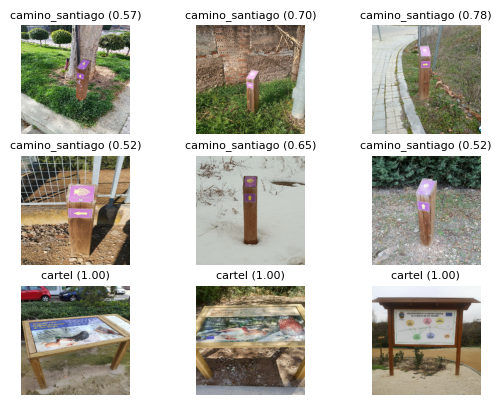

In [24]:
Y_matrix_au, Y_score_au = predict_dataset(x_test, red_hub_au)
sample_predict_ds_fd(x_test, Y_matrix_au)

                 precision    recall  f1-score   support

camino_santiago      1.000     1.000     1.000         6
         cartel      0.949     0.974     0.961        38
       marcador      1.000     0.200     0.333         5
         parque      0.929     0.981     0.954        53

       accuracy                          0.941       102
      macro avg      0.969     0.789     0.812       102
   weighted avg      0.944     0.941     0.929       102

Kappa de Cohen: 0.896
AUC (OvO): 0.975
AUC (OvR): 0.992


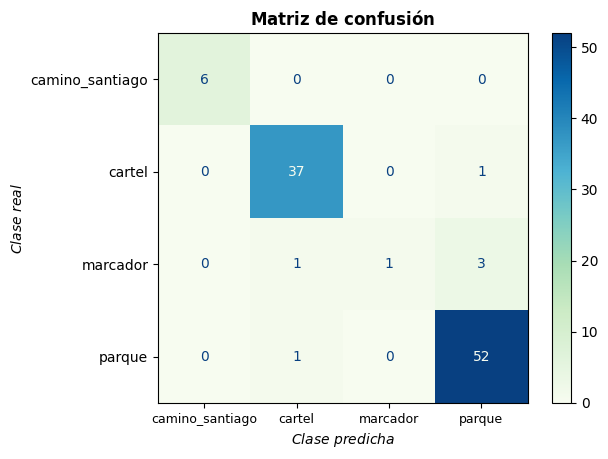

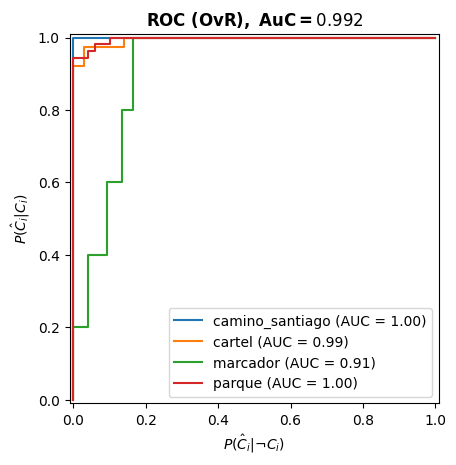

In [25]:
metricas_prediccion(x_test, Y_matrix_au, Y_score_au)

Ahora se puede hacer una comparación rápida de cómo las técnicas de transfer learning dan unos resultados mucho mejores que entrenar un modelo desde cero. 

In [26]:
red_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_conv.summary()
red_conv.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 173056)           

In [27]:
%load_ext tensorboard
red_conv.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs_cnn")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25


15/15 [==============================] - 7s 358ms/step - loss: 1.5246 - accuracy: 0.4307 - val_loss: 1.3025 - val_accuracy: 0.2650
Epoch 2/25
15/15 [==============================] - 6s 360ms/step - loss: 0.9369 - accuracy: 0.6418 - val_loss: 0.8752 - val_accuracy: 0.6154
Epoch 3/25
15/15 [==============================] - 6s 364ms/step - loss: 0.6817 - accuracy: 0.7633 - val_loss: 0.7935 - val_accuracy: 0.6667
Epoch 4/25
15/15 [==============================] - 6s 361ms/step - loss: 0.5178 - accuracy: 0.7974 - val_loss: 0.7417 - val_accuracy: 0.7265
Epoch 5/25
15/15 [==============================] - 6s 363ms/step - loss: 0.3407 - accuracy: 0.9083 - val_loss: 0.9857 - val_accuracy: 0.6325
Epoch 6/25
15/15 [==============================] - 6s 358ms/step - loss: 0.2646 - accuracy: 0.9147 - val_loss: 0.9359 - val_accuracy: 0.6496
Epoch 7/25
15/15 [==============================] - 6s 359ms/step - loss: 0.1951 - accuracy: 0.9510 - val_loss: 0.8835 - val_accuracy: 0.6752
Epoch 8/25
15/15 

                 precision    recall  f1-score   support

camino_santiago      0.333     0.167     0.222         6
         cartel      0.800     0.737     0.767        38
       marcador      0.000     0.000     0.000         5
         parque      0.810     0.887     0.847        53

       accuracy                          0.745       102
      macro avg      0.486     0.448     0.459       102
   weighted avg      0.739     0.745     0.739       102

Kappa de Cohen: 0.554
AUC (OvO): 0.779
AUC (OvR): 0.869


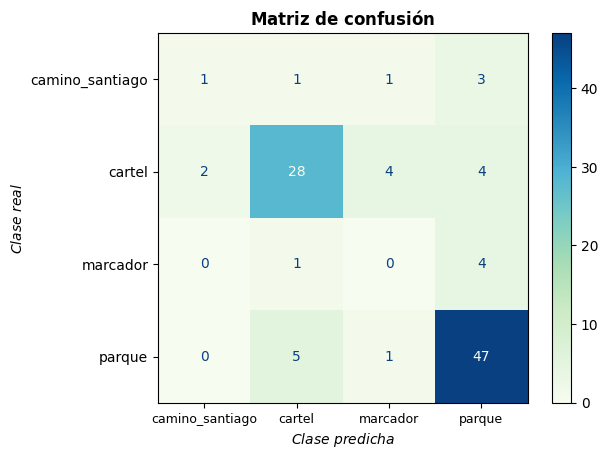

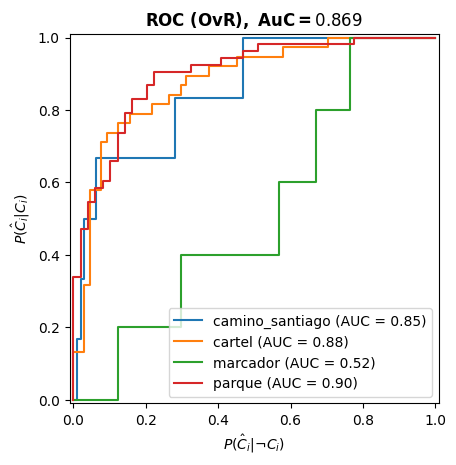

In [28]:
Y_matrix_conv, Y_score_conv = predict_dataset(x_test, red_conv)
metricas_prediccion(x_test, Y_matrix_conv, Y_score_conv)

Se nota que es peor, además de un claro sobreajuste en el entrenamiento, y que este es más costoso. Aún así para haberlo entrenado de cero y teniendo tan pocos datos, no está mal. Cuidado también con mirar sólo los AUC, algunos pueden tenerlo alto aún habiendo clasificado muy mal. Hay que mirarlos junto con la matriz de confusión. Se nota como con transfer learning, las capas convolucionales saben qué características obtener de la imagen, aquí no terminan de ser capaces y tienden a memorizar el dataset. 